In [16]:
!pip install -q torch torchvision diffusers transformers pillow numpy matplotlib opencv-python

In [17]:
import torch
from PIL import Image, ImageDraw#used to dram on the selected patches
import numpy as np
import cv2
import matplotlib.pyplot as plt
from diffusers import StableDiffusionInpaintPipeline#used to impaint the selected pathes, masks them
from transformers import CLIPProcessor, CLIPModel#model creates embeddings, processor images and text

device = "cuda" if torch.cuda.is_available() else "cpu"


In [18]:
# CLIP for vision-language understanding
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)

# Diffusion model for inpainting
diffusion_pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16#used 16 cause consumes half the memory of 32, also a bit faster but 32 gives more accuracy, better version
).to(device)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [19]:
def segment_by_color(image_pil, k=3):
    """Segment image into k color clusters, return masks for top clusters."""
    image = np.array(image_pil)
    data = image.reshape((-1, 3)).astype(np.float32)

    # Use k-means clustering in RGB space
    _, labels, centers = cv2.kmeans(
        data,
        k,
        None,
        (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0),#1st: ends the loop if centers travel less than e, 2nd: ends the loop if it attains max iter
        10,
        cv2.KMEANS_RANDOM_CENTERS
    )

    labels = labels.flatten()
    masks = []
    for cluster_idx in range(k):
        mask = labels.reshape(image.shape[:2]) == cluster_idx
        # Filter small masks
        if mask.sum() > 1000:
            masks.append(mask.astype(np.uint8) * 255)
    return masks


In [20]:
def prompt_understanding(image_pil, prompt):
    inputs = clip_processor(text=[prompt], images=image_pil, return_tensors="pt", padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = clip_model(**inputs)
    combined_embedding = (outputs.text_embeds + outputs.image_embeds) / 2
    return combined_embedding

def patchwise_edit(image_input, prompt, max_patches=1):
    # Accept either path string or PIL Image object
    if isinstance(image_input, str):
        image = Image.open(image_input).convert("RGB").resize((512, 512))
    elif isinstance(image_input, Image.Image):
        image = image_input.convert("RGB").resize((512, 512))
    elif isinstance(image_input, np.ndarray):
        image = Image.fromarray(image_input).convert("RGB").resize((512, 512))
    else:
        raise ValueError("Unsupported image input type")

    print("Segmenting image...")
    masks = segment_by_color(image, k=5)
    print(f"Found {len(masks)} masks")

    masks_sorted = sorted(masks, key=lambda m: np.sum(m), reverse=True)[:max_patches]

    edited = image.copy()
    for i, mask in enumerate(masks_sorted):
        print(f"Editing patch {i+1}/{len(masks_sorted)}...")

        mask_image = Image.fromarray(mask).convert("L")

        with torch.no_grad():
            result = diffusion_pipe(
                prompt=prompt,
                image=edited,
                mask_image=mask_image,
                guidance_scale=7.5,
                num_inference_steps=15
            ).images[0]
        edited = result

    return image, edited, masks_sorted

In [21]:
import os
import urllib.request

model_dir = "/content/models"
os.makedirs(model_dir, exist_ok=True)

sam_checkpoint_path = os.path.join(model_dir, "sam_vit_b_01ec64.pth")

if not os.path.exists(sam_checkpoint_path):
    print("Downloading SAM checkpoint...")
    urllib.request.urlretrieve(
        "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth",
        sam_checkpoint_path
    )
    print(f"SAM checkpoint downloaded to {sam_checkpoint_path}")
else:
    print(f"SAM checkpoint already exists at {sam_checkpoint_path}")

# Verify download
print(f"\nVerifying file exists: {os.path.exists(sam_checkpoint_path)}")
print(f"File size (MB): {os.path.getsize(sam_checkpoint_path) / (1024*1024):.2f}")


SAM checkpoint already exists at /content/models/sam_vit_b_01ec64.pth

Verifying file exists: True
File size (MB): 357.67


In [22]:
!pip install segment-anything


In [23]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

class SimpleSegmentation:
    def __init__(self):
        self.device = device
        checkpoint = "/content/models/sam_vit_b_01ec64.pth"
        print(f"Loading SAM model from {checkpoint}...")
        self.sam = sam_model_registry["vit_b"](checkpoint=checkpoint)
        self.sam.to(device=self.device)
        print("SAM loaded")

    def segment(self, image_np):
        mask_generator = SamAutomaticMaskGenerator(self.sam)
        masks = mask_generator.generate(image_np)
        masks = sorted(masks, key=lambda x: x['area'], reverse=True)[:3]
        binary_masks = [m['segmentation'].astype('uint8') * 255 for m in masks]
        return binary_masks

segmentation_model = SimpleSegmentation()
print("SAM ready")


Loading SAM model from /content/models/sam_vit_b_01ec64.pth...
SAM loaded
SAM ready


Running patchwise editing pipeline...
Image: [[[239 219 184]
  [240 221 184]
  [240 221 183]
  ...
  [234 215 177]
  [234 215 177]
  [233 214 176]]

 [[240 220 185]
  [240 221 184]
  [240 221 183]
  ...
  [235 216 178]
  [235 216 178]
  [234 215 177]]

 [[241 221 186]
  [241 222 185]
  [241 222 184]
  ...
  [236 217 179]
  [236 217 179]
  [235 216 178]]

 ...

 [[153 122  99]
  [152 122  97]
  [152 123  96]
  ...
  [141 110  87]
  [142 111  90]
  [140 109  88]]

 [[153 122 101]
  [152 121  98]
  [152 122  97]
  ...
  [141 111  88]
  [141 111  89]
  [141 110  89]]

 [[152 120 101]
  [151 120  98]
  [151 120  97]
  ...
  [139 108  86]
  [139 108  87]
  [140 109  88]]]
Prompt: add a tree

Segmenting image...
Found 5 masks
Editing patch 1/1...


  0%|          | 0/15 [00:00<?, ?it/s]

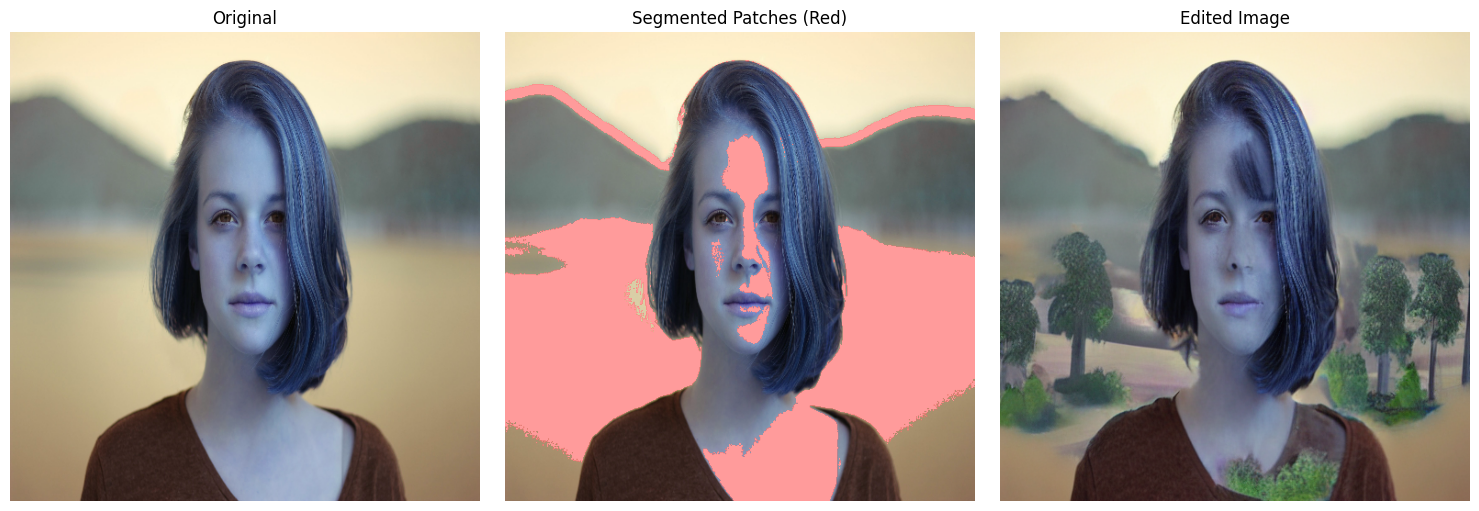

Pipeline complete!


In [27]:
prompt = "add a tree"

import cv2
image =cv2.imread('/content/girl.jpeg', cv2.IMREAD_COLOR)

resized_img = cv2.resize(image, (512, 512), interpolation=cv2.INTER_LINEAR)
input_image_path = resized_img

print(f"Running patchwise editing pipeline...")
print(f"Image: {input_image_path}")
print(f"Prompt: {prompt}\n")

orig_img, edited_img, masks = patchwise_edit(input_image_path, prompt, max_patches=1)

# Visualize masks on original image
def overlay_masks(image, masks):
    overlay = image.convert("RGBA")
    for m in masks:
        mask_img = Image.fromarray(m).convert("L").resize(image.size)
        red = Image.new("RGBA", image.size, (255, 0, 0, 100))
        overlay = Image.composite(red, overlay, mask_img)
    return overlay

overlayed = overlay_masks(orig_img, masks)

# Plot all images
fig, axs = plt.subplots(1, 3, figsize=(15,5))
axs[0].imshow(orig_img)
axs[0].set_title("Original")
axs[0].axis("off")

axs[1].imshow(overlayed)
axs[1].set_title("Segmented Patches (Red)")
axs[1].axis("off")

axs[2].imshow(edited_img)
axs[2].set_title("Edited Image")
axs[2].axis("off")

plt.tight_layout()
plt.show()

print("Pipeline complete!")
